# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a part of worlflow to develop an streamaligned mixed-element mesh for Taylor upstream watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN. This example has internal huc boundaries that are modified to accomodate river corridor. This workflow only shows steps to get a terrain following 2D surface mesh. Rest of the steps are same as other examples

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation

In [35]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import logging
import pandas as pd
pd.set_option('display.max_columns', None) 

import copy
import scipy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.regions
import watershed_workflow.resampling
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)

In [37]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries
modis_name = None

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 1980  # year to start and end simulation simulation -- note these start and end Oct 1 of the year
end_year = 2020
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

include_heterogeneous = True
include_homogeneous = False # if true, also write files for homogeneous runs
include_homogeneous_wrm = False # if true, also write files for homogeneous WRMs
include_homogeneous_wrm_porosity = False # if true, also write files for homogeneous porosity and WRMs
include_homogeneous_wrm_permeability = False # if true, also write files for homogeneous perm and WRMs

log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [38]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [39]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [40]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [41]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2025-04-30 14:47:51,879 - root - INFO: 
2025-04-30 14:47:51,880 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2025-04-30 14:47:51,881 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [42]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHDv2.1']
sources['HUC'] = watershed_workflow.source_list.huc_sources['WaterData WBD']
#sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)

2025-04-30 14:47:51,909 - root - INFO: Using sources:
2025-04-30 14:47:51,909 - root - INFO: --------------
2025-04-30 14:47:51,910 - root - INFO: HUC: WaterData
2025-04-30 14:47:51,910 - root - INFO: hydrography: WaterData
2025-04-30 14:47:51,910 - root - INFO: DEM: 3DEP


2025-04-30 14:47:53,572 - root - INFO: Removing holes on 3 polygons
2025-04-30 14:47:53,573 - root - INFO:   -- removed interior
2025-04-30 14:47:53,575 - root - INFO:   -- union
2025-04-30 14:47:53,576 - root - INFO: Parsing 1 components for holes
2025-04-30 14:47:53,576 - root - INFO:   -- complete


<Axes: >

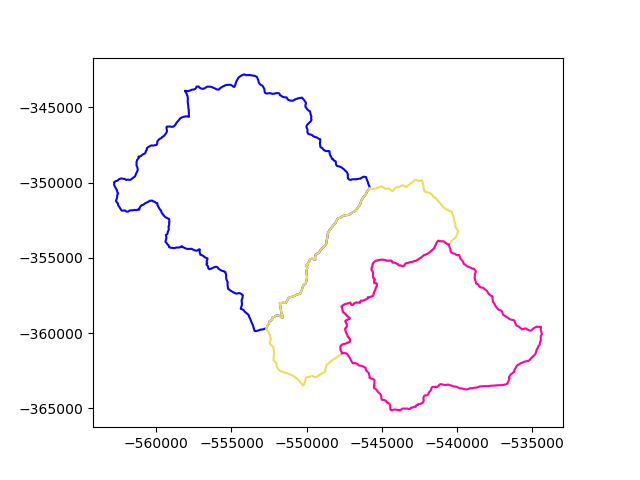

In [43]:
# load the huc
my_hucs = watershed_workflow.getShapesByID(sources['HUC'], hucs, crs, level=huc_level)
watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)
watershed.plot()

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [44]:
# what about the reservoir!
#_, waterbodies = watershed_workflow.get_waterbodies(sources['hydrography'], huc, my_hucs[0], crs, crs, 
#                                                    prune_by_area=prune_by_area_fraction_waterbodies*my_hucs[0].area)

While constructing river, user should be intetntional with prune options to get desired river network density. It is recommended to not have too dense river network if not needed as each reach in the river tree will show up in quad mesh

In [45]:
include_rivers = True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    reaches = watershed_workflow.getShapesByGeometry(sources['hydrography'], watershed.exterior, crs, crs)
    rivers = watershed_workflow.river_tree.createRivers(reaches, method='hydroseq')

watershed_orig, rivers_orig = watershed, rivers

This watershed has three subwatersheds. The internal watershed boundaries will be accomodated in the river mesh

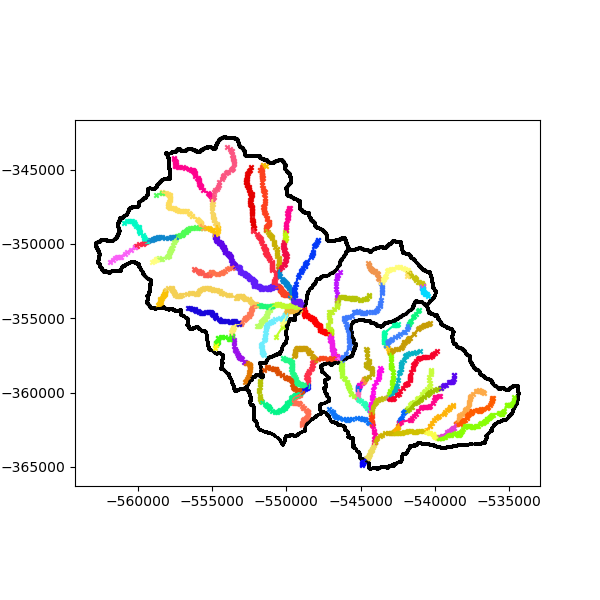

In [46]:
def plot(ws, rivs, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    ws.plot(color='k', marker='+', markersize=10, ax=ax)
    for river in rivs:
        river.plot(marker='x', markersize=10, ax=ax)

plot(watershed, rivers)

In the simplification step below, we keep the original river so that we can sample vertices from these original dense rivers and huc boundaries to get vertex density at desired resolution.

Using the Douglas-Peucker algorithm, we simplify the flowline by removing non-essential vertices with shapely's "simplify" method, ensuring accurate representation. Additional simplifications, such as merging minor reaches and aligning watershed boundaries with flowlines, are also performed. 

TIPS:
- keep merge tolerance about 70% of the simplify_rivers tolerance
- use smaller snap tolerance (50% of simplify_rivers) if non-outlet reaches start snapping to the watershed boundaries


In step two, we enhance the flowline's resolution by adding nearly uniformly distributed vertices, sampled from the original to regain any curvature lost during simplification, with an upper user-defined limit dictating the distance between consecutive vertices, ultimately determining the quad length in the river mesh. When the distance in a reach linestring, represented as a shapely.LineString object, surpasses this scale, additional vertices are inserted, their number and coordinates derived using 1D interpolation from the original linestring vertices.

The limit of distance between vertices on the huc boundary is a function of distance from the river. Parts of huc linestrings close to river get vertices placd at higher density.

Sharp bends in the river and tributaries running closely before merging are a couple of cases that can constrain triangulation to yield small triangles. Hence, we smoothen out some of these sharp angles

TIPS:

    provide L0 about same as length scale limit on river and L1 about 1.5 to 2 times times length scale limit on river
    profile d1 atleast equal to length scale limit on river



In [47]:
# keeping the originals for plotting comparisons
def createCopy(watershed, rivers):
    """To compare before/after, we often want to create copies.  Note in real workflows most things are done in-place without copies."""
    return watershed.deepcopy(), [r.deepcopy() for r in rivers]
    
watershed, rivers = createCopy(watershed_orig, rivers_orig)

# simplifying 
watershed_workflow.simplify(watershed, rivers, 100, 250, 100, 1000)

2025-04-30 14:47:56,330 - root - INFO: 
2025-04-30 14:47:56,330 - root - INFO: Simplifying
2025-04-30 14:47:56,330 - root - INFO: ------------------------------
2025-04-30 14:47:56,330 - root - INFO: Presimplify to remove colinear, coincident points.
2025-04-30 14:47:56,334 - root - INFO: Pruning leaf reaches < 100
2025-04-30 14:47:56,335 - root - INFO: Merging internal reaches < 100
2025-04-30 14:47:56,340 - root - INFO:   reach: min seg length: 	    5.6644414012 	min geom length: 	   93.1348665372
2025-04-30 14:47:56,340 - root - INFO:   reach: med seg length: 	   81.3994298966 	med geom length: 	 1761.5611814360
2025-04-30 14:47:56,340 - root - INFO:   reach: max seg length: 	  808.6825879278 	max geom length: 	 7537.3551206404
2025-04-30 14:47:56,341 - root - INFO: 
2025-04-30 14:47:56,342 - root - INFO:   HUC  : min seg length: 	    8.1290974281 	min geom length: 	 8742.6840131792
2025-04-30 14:47:56,342 - root - INFO:   HUC  : med seg length: 	   33.0898427102 	med geom length: 	

In [48]:
# this should generate a zoomable map, showing different reaches and watersheds, 
# with discrete points.  Problem areas are clickable to get IDs for manual
# modifications.
m = watershed.explore(marker=False)
for river in rivers_orig:
    m = river.explore(m=m, column=None, color='black', name=river['name']+' raw', marker=False)
for river in rivers:
    m = river.explore(m=m)
    
m = watershed_workflow.makeMap(m)
m

In [49]:
# how many types of Stream Orders are there
set([r.properties['stream_order'] for r in rivers[0].preOrder()])

{np.int64(1), np.int64(2), np.int64(3), np.int64(4)}

Widths in the river corridor mesh (quads) is given through dictionary of Stream Order:Width. One way to get these values is to do a quick survey on GIS map and see for the given watershed, what are typical widths of different stream orders. Or, user may also provide width as a function of drainage area. 

2025-04-30 14:47:58,387 - root - INFO: 
2025-04-30 14:47:58,388 - root - INFO: Stream-aligned Meshing
2025-04-30 14:47:58,388 - root - INFO: ------------------------------
2025-04-30 14:47:58,388 - root - INFO: Creating stream-aligned mesh...
2025-04-30 14:47:58,756 - root - INFO: Adjusting HUC to match reaches at outlet
2025-04-30 14:47:58,764 - root - INFO: Adjusting HUC to match reaches at reach 1332846 and coordinate (-546348.9429845376, -357841.9509549553)
2025-04-30 14:47:58,775 - root - INFO: Adjusting HUC to match reaches at reach 1332728 and coordinate (-548915.8617565744, -354311.3539136959)


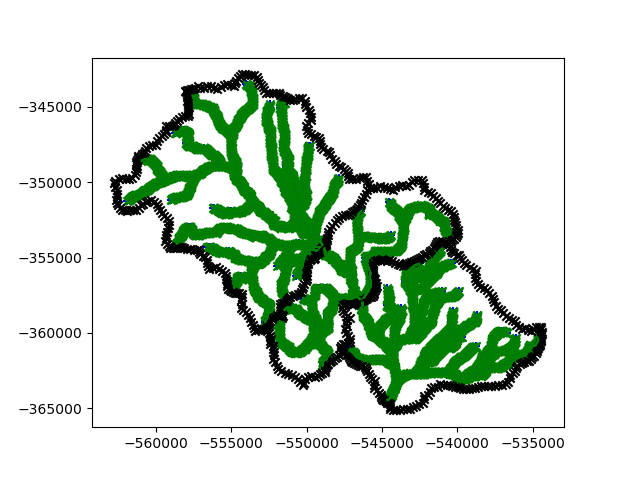

2025-04-30 14:48:02,810 - root - INFO: 
2025-04-30 14:48:02,810 - root - INFO: Triangulation
2025-04-30 14:48:02,810 - root - INFO: ------------------------------
2025-04-30 14:48:02,811 - root - INFO: Triangulating...
2025-04-30 14:48:02,821 - root - INFO:    5304 points and 5309 facets
2025-04-30 14:48:02,823 - root - INFO:  checking graph consistency
2025-04-30 14:48:02,824 - root - INFO:  tolerance is set to 1.0
2025-04-30 14:48:02,844 - root - INFO:  building graph data structures
2025-04-30 14:48:02,860 - root - INFO:  triangle.build...
2025-04-30 14:49:24,757 - root - INFO:   ...built: 13096 mesh points and 21059 triangles
2025-04-30 14:49:24,758 - root - INFO: Plotting triangulation diagnostics
2025-04-30 14:49:25,943 - root - INFO:   min area = 281.28070068359375
2025-04-30 14:49:25,943 - root - INFO:   max area = 49994.25811767578


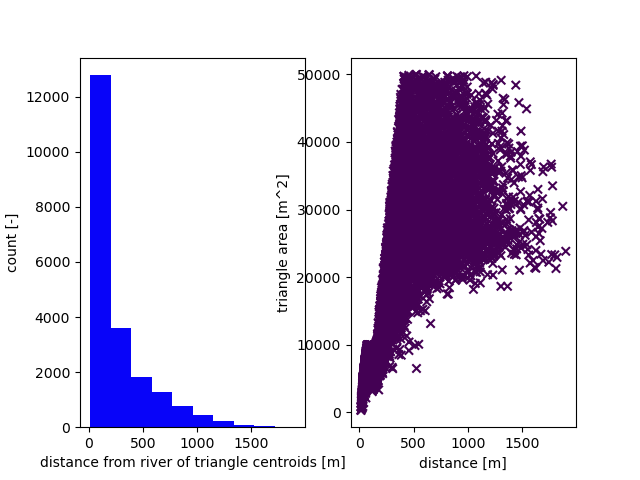

In [50]:
### %pdb
## Triangulation

refine_d0 = 150 
refine_d1 = 400
refine_A0 = 10000
refine_A1 = 50000

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 20 # degrees

# width of reach by stream order (order:width)
widths = dict({1:10, 2:10, 3:20, 4:30}) 

m2, area, dists = watershed_workflow.tessalateRiverAligned(watershed, rivers, river_width=widths,
                                              refine_min_angle=min_angle, refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True, debug=True)

In [51]:
# get a raster for the elevation map, based on NED
dem = sources['DEM'].getDataset(watershed.exterior.buffer(100), watershed.crs)

# provide surface mesh elevations
watershed_workflow.elevate(m2, dem)

In [86]:
watershed_ls = list(watershed.linestrings)

In [79]:
watershed.df

,geometry,tnmid,metasourceid,sourcedatadesc,sourceoriginator,sourcefeatureid,loaddate,gnis_id,areaacres,areasqkm,states,huc12,name,hutype,humod,tohuc,noncontributingareaacres,noncontributingareasqkm,globalid,huc,area,ID_as_column
ID,,,,,,,,,,,,,,,,,,,,,,
140200010101,"POLYGON ((-552707.662 -359735.398, -552644.692...",{21773160-4973-4E00-92C3-DD479AFAE742},{6A40B4E3-27CB-4306-A791-9EE00248731D},None,None,None,2017-10-25T09:19:09Z,None,39868.71,161.34,CO,140200010101,Headwaters Taylor River,S,NM,140200010102,0,0,{94590908-E29C-11E2-8094-0021280458E6},140200010101,161.34,140200010101
140200010102,"POLYGON ((-552707.662 -359735.398, -552644.692...",{EE751AFA-C152-48BA-84F6-C350C3CBE8A8},{6A40B4E3-27CB-4306-A791-9EE00248731D},None,None,None,2017-10-25T09:19:09Z,None,18446.75,74.65,CO,140200010102,Upper Taylor River,S,NM,140200010103,0,0,{94591FCE-E29C-11E2-8094-0021280458E6},140200010102,74.65,140200010102
140200010103,"POLYGON ((-547663.783 -361361.547, -547721.212...",{AA793CF4-2019-40A2-9EC0-20ACEA582CC5},None,None,None,None,2013-01-18T07:08:08Z,None,23752.55,96.12,CO,140200010103,Middle Taylor River,S,NM,140200010107,0,0,{94593DC4-E29C-11E2-8094-0021280458E6},140200010103,96.12,140200010103


In [90]:
import geopandas as gpd

<Axes: >

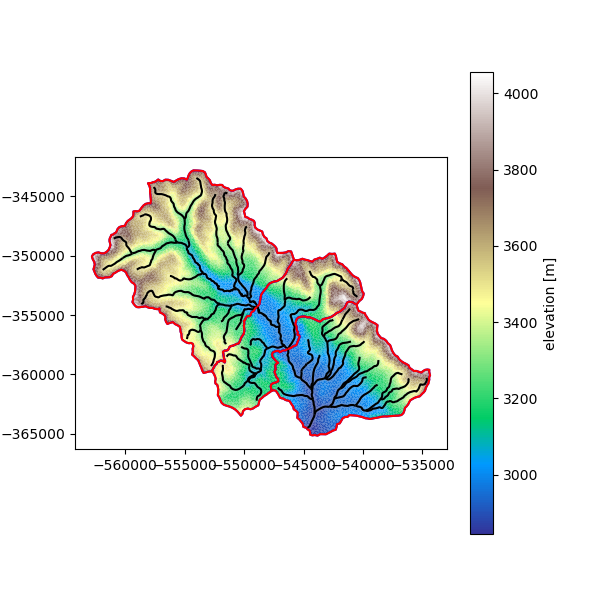

In [95]:
fig, ax = plt.subplots(figsize=(6,6))
watershed_workflow.plot.mesh(m2, color='elevation', ax=ax, legend=True, cmap='terrain', legend_kwds={'orientation': 'vertical', 'label': 'elevation [m]'})
df2= gpd.GeoDataFrame({'geometry':list(watershed.linestrings)})
watershed.plot(color='b', ax=ax)
rivers[0].plot(ax=ax, color = 'k')
watershed_workflow.plot.linestringsWithCoords(df2, ax=ax, color='r')

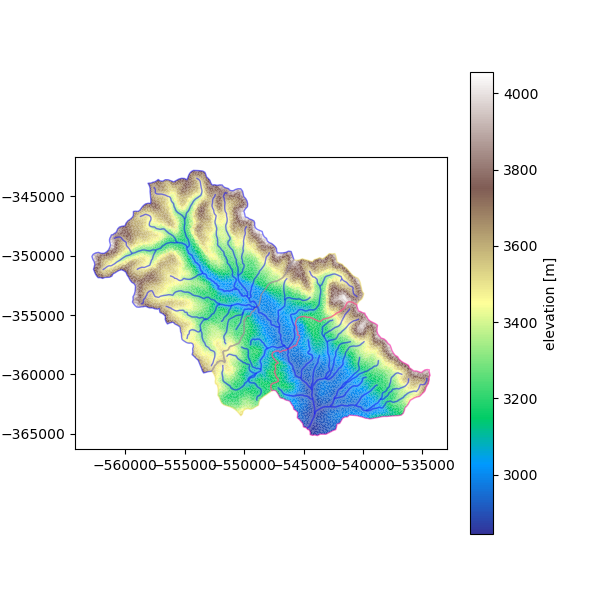

In [78]:
fig, ax = plt.subplots(figsize=(6,6))
watershed_workflow.plot.mesh(m2, color='elevation', ax=ax, legend=True, cmap='terrain', legend_kwds={'orientation': 'vertical', 'label': 'elevation [m]'})
watershed.plot(ax=ax, alpha = 0.5, linewidth=1)
rivers[0].plot(ax=ax, color='b',alpha = 0.5, linewidth=1 )
plt.show()

In [53]:
import copy
m2_before_conditioning = copy.deepcopy(m2)

In the pit-filling algorithm, we want to make sure that river corridor is not filled up. Hence we exclude river corridor cells from the pit-filling algorithm.

In [54]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fillPitsDual(m2, is_waterbody=river_mask)

There are a range of options to condition river corridor mesh. We hydrologically condition the river mesh, ensuring unimpeded water flow in river corridors by globally adjusting flowlines to rectify artificial obstructions from inconsistent DEM elevations or misalignments. Please read the documentation for more information


In [55]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.setProfileByDEM(rivers, dem)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.conditionRiverMeshes(m2, rivers)

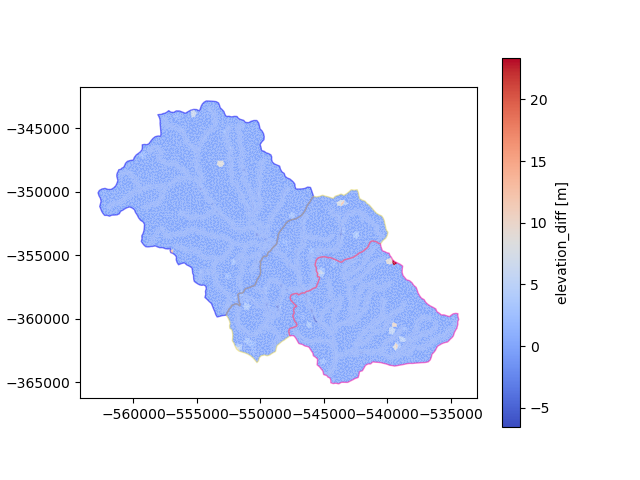

In [56]:
m2_diff = copy.deepcopy(m2)
m2_diff.coords[:,2] = m2.coords[:,2] - m2_before_conditioning.coords[:,2]

# plot the resulting surface mesh
fig, ax = plt.subplots()

watershed_workflow.plot.mesh(m2_diff, color='elevation', ax=ax, legend=True, cmap='coolwarm', legend_kwds={'orientation': 'vertical', 'label': 'elevation_diff [m]'})
watershed.plot(ax=ax, alpha=0.5, linewidth=1)

plt.show()

In [69]:
list(watershed.linestrings)

[<LINESTRING (-552707.662 -359735.398, -552862.36 -359743.172, -553024.101 -3...>,
 <LINESTRING (-547663.783 -361361.547, -547816.933 -361476.079, -547980.425 -...>,
 <LINESTRING (-545801.114 -350360.281, -545564.672 -350404.754, -545325.11 -3...>,
 <LINESTRING (-540531.521 -354109.421, -540497.195 -354298.646, -540440.345 -...>,
 <LINESTRING (-552707.662 -359735.398, -552644.692 -359603.96, -552593.74 -35...>,
 <LINESTRING (-547663.783 -361361.547, -547721.212 -361191.04, -547758.143 -3...>,
 <LINESTRING (-540531.521 -354109.421, -540702.981 -354050.414, -540842.355 -...>,
 <LINESTRING (-545801.114 -350360.281, -545958.395 -350545.307, -546061.56 -3...>,
 <LINESTRING (-544728.208 -364526.35, -544791.351 -364473.457, -544893.546 -3...>]

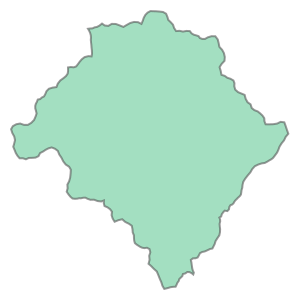

In [77]:
watershed.computePolygon(0)

In [63]:
list(watershed.polygons())

2025-04-30 16:07:38,447 - root - INFO: LINESTRING (-547663.7829344553 -361361.54692524637, -547816.9328248316 -361476.07914908347, -547980.4249671533 -361581.7987204512, -548112.7451953515 -361690.9234162432, -548247.1619848291 -361767.883253063, -548363.9885721181 -361851.9441200339, -548463.6450192431 -361943.25330630684, -548565.1524784977 -362027.2208890381, -548670.569805346 -362110.9874119524, -548716.5712789805 -362226.6496741045, -548746.7718072812 -362340.1724677506, -548768.2426397583 -362463.05938407616, -548807.2190419842 -362596.36106291274, -548945.317186579 -362665.595921192, -549090.3529529466 -362749.2194410199, -549246.2043019045 -362857.18946880125, -549451.1224824596 -362926.8898713026, -549681.4954505223 -362865.5119583696, -549920.1227066676 -362923.4495536183, -550080.5639946123 -363078.8878153744, -550139.7783274967 -363320.35039243766, -550265.5539697803 -363465.4630030143, -550418.4303266088 -363270.68427425035, -550584.713771916 -363084.6147106408, -550775.27

AssertionError: 

In [59]:
# find outlet
watershed_workflow.hydrography.findOutletsByCrossings(watershed, rivers[0], debug_plot=True)

2025-04-30 15:58:01,998 - root - INFO: LINESTRING (-547663.7829344553 -361361.54692524637, -547816.9328248316 -361476.07914908347, -547980.4249671533 -361581.7987204512, -548112.7451953515 -361690.9234162432, -548247.1619848291 -361767.883253063, -548363.9885721181 -361851.9441200339, -548463.6450192431 -361943.25330630684, -548565.1524784977 -362027.2208890381, -548670.569805346 -362110.9874119524, -548716.5712789805 -362226.6496741045, -548746.7718072812 -362340.1724677506, -548768.2426397583 -362463.05938407616, -548807.2190419842 -362596.36106291274, -548945.317186579 -362665.595921192, -549090.3529529466 -362749.2194410199, -549246.2043019045 -362857.18946880125, -549451.1224824596 -362926.8898713026, -549681.4954505223 -362865.5119583696, -549920.1227066676 -362923.4495536183, -550080.5639946123 -363078.8878153744, -550139.7783274967 -363320.35039243766, -550265.5539697803 -363465.4630030143, -550418.4303266088 -363270.68427425035, -550584.713771916 -363084.6147106408, -550775.27

AssertionError: 

In [ ]:
# add labeled sets for subcatchments and outlets
watershed_workflow.regions.add_watershed_regions_and_outlets(m2, watershed, outlet_width=stream_outlet_width, 
                                                          labels=[p.properties[huc_key] for p in watershed.polygons()], exterior_outlet= True)

# add labeled sets for river corridor cells
watershed_workflow.regions.add_river_corridor_regions(m2, rivers)


# add labeled sets for river corridor cells by order
watershed_workflow.regions.add_regions_by_stream_order_rivers(m2, rivers, labels=None)

In [ ]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : {len(ls.ent_ids)} : "{ls.name}"')